In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [4]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'CRL_moon_cifar.ipynb', 'Cifar_baseline.ipynb', 'Cifar_baseline_ResNet.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'DAC+Temp_Cifar_dropout_swin.ipynb', 'DAC+Temp_Cifar_mixup_labelsmoothing_swin.ipynb', 'DAC+Temp_Cifar_swin.ipynb', 'Dropout.ipynb', 'Dropout_cifar.ipynb', 'FocalLoss.ipynb', 'FocalLoss_cifar.ipynb', 'LabelSmoothing.ipynb', 'LabelSmoothing_cifar.ipynb', 'Mixup.ipynb', 'Mixup_cifar.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_LS.json', 'results_ECE_LS_cifar

split the CIFAR-10 dataset into two non-overlapping halves: one half for training and validation (in-distribution), and the other half for testing (out-of-distribution). This code first splits the full CIFAR-10 training dataset into two halves. The first half is further split into training and validation subsets. The second half is used entirely for testing. This ensures that the training/validation and test datasets are completely non-overlapping.

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset,Dataset
import torchvision.models as models
import torch
from torchvision.transforms import ToPILImage
import numpy as np
import random
from PIL import Image


model = models.resnet50(pretrained=True) #pretrained on imagenet which have 1000 images
num_features = model.fc.in_features  # Get the input features of the final fully connected layer
model.fc = torch.nn.Linear(num_features, 10)  # Replace it with a new fully connected layer with 10 outputs


# Custom Dataset class to load images on-the-fly
class CIFARC_Dataset(Dataset):
    def __init__(self, data: np.ndarray, labels: list, transform=None):
        assert len(data) == len(labels)
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CIFAR images are in the format (channels, height, width)
        # We need to convert them to (height, width, channels) for PIL
        img = self.data[idx].transpose((1, 2, 0))  # Convert to HxWxC
        img = Image.fromarray(img.astype('uint8'), 'RGB')  # Convert to PIL Image
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

class CombinedCIFARCDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(f"Index out of range: {idx}")

        # Determine which dataset the index falls into
        dataset_idx = np.searchsorted(self.cumulative_lengths, idx, side='right')
        if dataset_idx > 0:
            relative_idx = idx - self.cumulative_lengths[dataset_idx - 1]
        else:
            relative_idx = idx

        return self.datasets[dataset_idx][relative_idx]


# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get the labels from the CIFAR-10 test set
test_labels = full_test_dataset.targets

# Load CIFAR-10-C dataset
file_path = './data/CIFAR-10-C/zoom_blur.npy'  # Make sure this path is correct
cifar_c_data_blur = np.load(file_path)
cifar_c_data_blur = cifar_c_data_blur.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_blur = CIFARC_Dataset(data=cifar_c_data_blur[:500], labels=test_labels[:500], transform=transform)


file_path = './data/CIFAR-10-C/speckle_noise.npy'  # Make sure this path is correct
cifar_c_data_speckle = np.load(file_path)
cifar_c_data_speckle = cifar_c_data_speckle.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_speckle = CIFARC_Dataset(data=cifar_c_data_speckle[:500], labels=test_labels[:500], transform=transform)
# Instantiate the Combined Dataset with blur and speckle datasets
combined_cifar_c_dataset = CombinedCIFARCDataset([cifar_c_dataset_blur, cifar_c_dataset_speckle])
# Define DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_subset, test_subset = random_split(full_test_dataset, [len(full_test_dataset) // 2, len(full_test_dataset) - len(full_test_dataset) // 2])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)
# Define a DataLoader for the combined dataset
OD_loader = DataLoader(combined_cifar_c_dataset, batch_size=64, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Files already downloaded and verified
Files already downloaded and verified


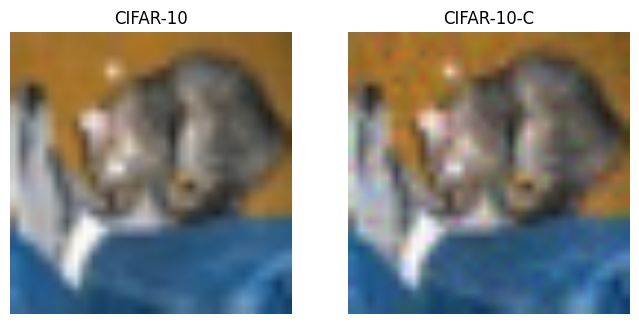

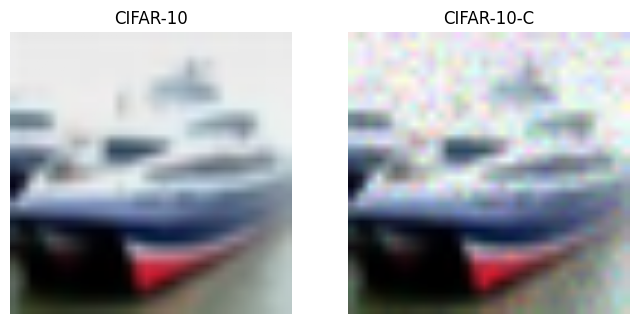

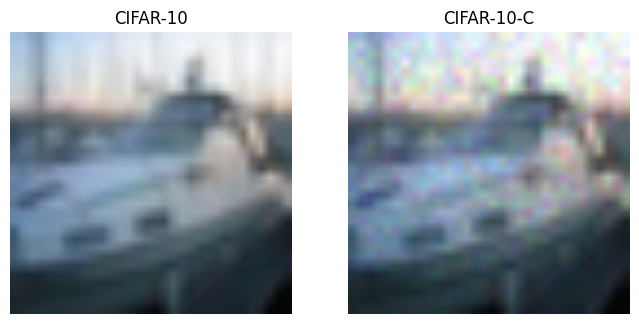

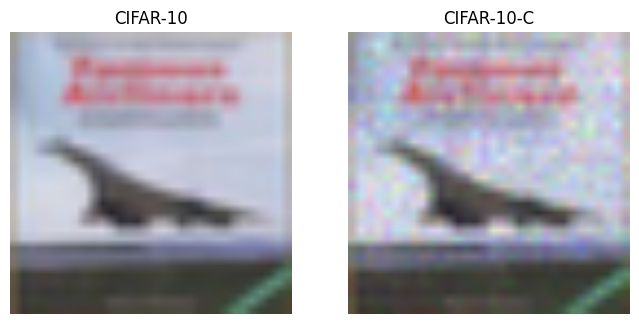

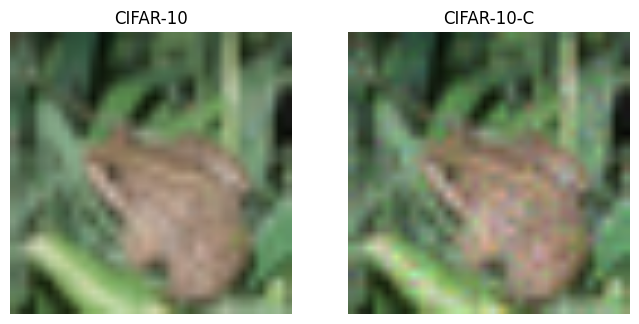

In [6]:
import matplotlib.pyplot as plt

# Function to display images for comparison
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # The inplace operations are used to save memory
    return tensor
def show_images(img1, img2, title1='CIFAR-10', title2='CIFAR-10-C'):
    # Unnormalize the images
    img1 = unnormalize(img1.clone(), mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
    img2 = unnormalize(img2.clone(), mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1.permute(1, 2, 0))
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(img2.permute(1, 2, 0))
    axes[1].set_title(title2)
    axes[1].axis('off')

    plt.show()

# Compare a few pairs of images
for i in range(5):  # Compare 5 pairs of images
    # Get images from CIFAR-10 test set and CIFAR-10-C
    cifar_image, _ = full_test_dataset[i]  # This image is already a tensor and normalized
    cifar_c_image, _ = cifar_c_dataset_speckle[i]  # change the npy corrpution dataset here to inspect if the image is indeed the same order

    # Display the images
    show_images(cifar_image, cifar_c_image)

This new class aims to modify the provided original_model (in this case, a ResNet model) to not only return the final output (class probabilities) but also the feature representations from the layer before the final fully connected (FC) layer.

The feature extraction part (named self.features) is created by taking all layers from the original_model except the last one (the final FC layer). This is achieved using the list(original_model.children())[:-1] command. The purpose is to get the feature maps before they are flattened and passed through the final FC layer.
The final FC layer (self.fc) is separately stored, as it will be used to produce the final output.

The forward method takes an input tensor x and passes it through the feature extraction layers.
These feature maps are then flattened and passed through the final FC layer to get the model's output.
The function returns both the final output and the feature maps, providing dual functionality: standard prediction and feature extraction.


In [7]:
pip install tqdm tensorboard

In [11]:
import torch
import torch.optim as optim
from torch import nn
from tqdm.notebook import tqdm  # for a nice progress bar
import matplotlib.pyplot as plt


train_losses = []
val_accuracies = []

# Parameters
num_epochs = 5 # can stop early with key interrupt if the accuracy is not increasing anymore, optimal epoch is 20
learning_rate = 0.0001

# Using CUDA if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # We only need the outputs for loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Record the average loss per epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

   # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print("Finished Training")

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/5] Loss: 0.1307
Validation Accuracy: 94.32%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/5] Loss: 0.0760
Validation Accuracy: 95.00%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/5] Loss: 0.0591
Validation Accuracy: 94.70%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/5] Loss: 0.0468
Validation Accuracy: 94.24%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/5] Loss: 0.0413
Validation Accuracy: 94.16%
Finished Training


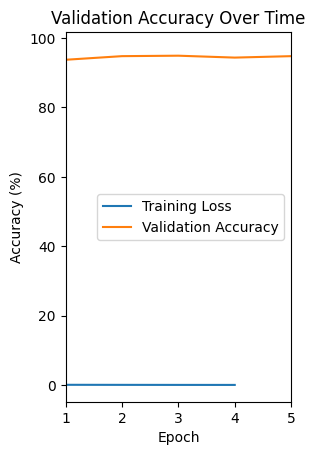

In [12]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [20]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE) for ID BEFORE CALIBRATION: {ece:.4f}")


probs = torch.tensor([]).to(device)
true_labels_od = torch.tensor([]).to(device)
model = model.to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels_od = torch.cat([true_labels_od, labels], dim=0)


ece_od = compute_ece(probs, true_labels_od)
print(f"Expected Calibration Error (ECE) for OD data BEOFRE CALIBRATION: {ece_od:.4f}")

Expected Calibration Error (ECE) for ID BEFORE CALIBRATION: 0.0325
Expected Calibration Error (ECE) for OD data BEOFRE CALIBRATION: 0.0944


In [16]:
# Sample test result and current datetime
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_cifar_baseline.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')
